In [2]:
%pip install lightfm
%pip install gensim=='3.8.3'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [254]:
print(gensim.__version__)

3.8.3


In [1]:
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM

In [2]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

import nltk
from nltk.tokenize import RegexpTokenizer


In [3]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

# Домашнее задание

Data contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### 1. Реализовать персональный топ  - принимает на вход возраст и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок

Коллаборативную фильтрацию реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл.

Для Content-based, Коллаборативной фильтрации, Матричной Факторизации реализовать U2I и I2I рекомендации

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации

Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)

Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

# Жесткий дедлайн 12 мая

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.

In [4]:
books = pd.read_csv("HW_files/BX-Books.csv")

/home/alexey/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
interactions = pd.read_csv("HW_files/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [6]:
interactions = interactions[interactions["Book-Rating"] != 0]

In [7]:
books_meets = interactions.groupby("ISBN")["User-ID"].count()

In [8]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [9]:
# books_meets.sort_values(by='user_num', ascending=False).reset_index()

In [10]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [11]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [12]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [13]:
users = pd.read_csv('HW_files/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

In [14]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [16]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [17]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

In [18]:
interactions[interactions['vid'] == 1]

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
883,99,0451166892,3,87,8,http://images.amazon.com/images/P/0451166892.0...,The Pillars of the Earth,5415,1
10671,99,0446677450,10,42,8,http://images.amazon.com/images/P/0446677450.0...,"Rich Dad, Poor Dad: What the Rich Teach Their ...",5105,1
12972,99,0312252617,8,9,8,http://images.amazon.com/images/P/0312252617.0...,Fast Women,1386,1
51337,99,0312261594,8,14,8,http://images.amazon.com/images/P/0312261594.0...,Female Intelligence,1393,1
51346,99,0316748641,7,6,8,http://images.amazon.com/images/P/0316748641.0...,Pasquale's Nose: Idle Days in an Italian Town,1710,1


### Ищем id нужных книг

In [19]:
for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
    if "David Copperfield" in j:
        print("idx:", i, "\tBook Title:", j)

idx: 10174 	Book Title: David Copperfield (Wordsworth Classics)
idx: 1074 	Book Title: David Copperfield (Penguin Classics)


# 1. Персональный топ

In [20]:
# Наши предобработанные данные
# user_num - количество  пользователей, которые провзаимодействовавшие с данной книгой
# books_num - количество книг, с которыми провзаимодействовал данный пользователь
# product_id - label_enc к столбцу ISBN
# vid - label_enc к столбцу User-ID
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228


<font size = 4>Выведем данные, которые имеем

In [21]:
# users df - состоит из id юзера, его локации (место обитания), возраста
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [22]:
# посмотрим сколько уникальных локаций
print(len(users['Location'].unique()))
users['Location'].unique()

57339


array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

In [23]:
%%time
# Добавим еще одну колонку
pattern = r'\w+ \w+|\w+/\w+|\w+.\w+.\w+|\w+'
tokenizer = RegexpTokenizer(pattern)
users['tokenized_location'] = users.apply(lambda row: tokenizer.tokenize(row['Location']), axis=1)

CPU times: user 4.81 s, sys: 74.6 ms, total: 4.88 s
Wall time: 4.89 s


In [24]:
users

,User-ID,Location,Age,tokenized_location
0,1,"nyc, new york, usa",NaN,"[nyc, new york, usa]"
1,2,"stockton, california, usa",18.0,"[stockton, california, usa]"
2,3,"moscow, yukon territory, russia",NaN,"[moscow, yukon territory, russia]"
3,4,"porto, v.n.gaia, portugal",17.0,"[porto, v.n.gaia, portugal]"
4,5,"farnborough, hants, united kingdom",NaN,"[farnborough, hants, united kingdom]"
...,...,...,...,...
278853,278854,"portland, oregon, usa",NaN,"[portland, oregon, usa]"
278854,278855,"tacoma, washington, united kingdom",50.0,"[tacoma, washington, united kingdom]"
278855,278856,"brampton, ontario, canada",NaN,"[brampton, ontario, canada]"
278856,278857,"knoxville, tennessee, usa",NaN,"[knoxville, tennessee, usa]"


In [25]:
# users.drop(columns='city', inplace=True)

In [26]:
# Добавим возрастные периоды читателей, возможно не самые оптимальные, но почему бы и нет:
# 0: до 6
# 1: 7 - 12
# 2: 13 - 17
# 3: 18 - 35
# 4: 36 - 55
# 5: 56 - 70
# 6: 70+
users['age_period'] = users['Age']
users.loc[users['age_period'] == 0, 'age_period'] = -1
users.loc[(users['age_period'] >= 1) & (users['age_period'] <= 6), 'age_period'] = 0
users.loc[(users['age_period'] > 6) & (users['age_period'] <= 13), 'age_period'] = 1
users.loc[(users['age_period'] > 13) & (users['age_period'] <= 17), 'age_period'] = 2
users.loc[(users['age_period'] > 17) & (users['age_period'] <= 35), 'age_period'] = 3
users.loc[(users['age_period'] > 35) & (users['age_period'] <= 55), 'age_period'] = 4
users.loc[(users['age_period'] > 55) & (users['age_period'] <= 70), 'age_period'] = 5
users.loc[(users['age_period'] > 70) & (users['age_period'] <= 99), 'age_period'] = 6

# Заменим NaN и значение возраста > 99 на -1
users.loc[pd.isnull(users['age_period']), 'age_period'] = -1
users.loc[users['age_period'] > 99, 'age_period'] = -1
# users['age_period'] = users['age_period'].astype(int)

In [27]:
users.head()

,User-ID,Location,Age,tokenized_location,age_period
0,1,"nyc, new york, usa",NaN,"[nyc, new york, usa]",-1.0
1,2,"stockton, california, usa",18.0,"[stockton, california, usa]",3.0
2,3,"moscow, yukon territory, russia",NaN,"[moscow, yukon territory, russia]",-1.0
3,4,"porto, v.n.gaia, portugal",17.0,"[porto, v.n.gaia, portugal]",2.0
4,5,"farnborough, hants, united kingdom",NaN,"[farnborough, hants, united kingdom]",-1.0


In [28]:
# Видно, что есть рофлоданные, будем учитывать возрастную рекомендацию, только при возрасте < 99
users['Age'].value_counts()

24.0     5687
25.0     5618
26.0     5547
23.0     5456
27.0     5383
         ... 
229.0       1
159.0       1
175.0       1
137.0       1
226.0       1
Name: Age, Length: 165, dtype: int64

Хочу реализовать довольно простую логику:
если один из аргументов: age или location пропущен, то реализую фильтрацию по другому, затем нахожу средний рейтинг. Создаю топ, рекоменую.
Если пропущены оба, то просто вывожу international топ.
Если оба заданы, фильтрую df по возрастной категории и по локации.


In [29]:
users[(users['age_period'] == 2)]

,User-ID,Location,Age,tokenized_location,age_period
3,4,"porto, v.n.gaia, portugal",17.0,"[porto, v.n.gaia, portugal]",2.0
10,11,"melbourne, victoria, australia",14.0,"[melbourne, victoria, australia]",2.0
18,19,"weston, ,",14.0,[weston],2.0
34,35,"grafton, wisconsin, usa",17.0,"[grafton, wisconsin, usa]",2.0
40,41,"santee, california, usa",14.0,"[santee, california, usa]",2.0
...,...,...,...,...,...
278784,278785,"gustow, mecklenburg-vorpommern, germany",16.0,"[gustow, mecklenburg-vorpommern, germany]",2.0
278793,278794,"st. paul, minnesota, usa",14.0,"[st, paul, minnesota, usa]",2.0
278817,278818,"allentown, pennsylvania, usa",15.0,"[allentown, pennsylvania, usa]",2.0
278837,278838,"massillon, ohio, usa",15.0,"[massillon, ohio, usa]",2.0


In [30]:
interactions[(interactions['User-ID'] == 32257)]

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid


In [31]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        

def simple_rec_imaging(picture_urls, measure=None, top_n=4):
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [32]:
# Тестовая реализация. Можно запариться не со средней оценкой, а более корректной, чтобы не переоценивать 
# непопулярные книги с высокой оценкой.
class TopBooks():
    def __init__(
        self, 
        interaction_df: pd.DataFrame, 
        users_df: pd.DataFrame, 
        age=None, 
        locality=None,
        state=None,
        country=None,
        top_count=8,
        min_len=100 # Минимальное количество строк, необходимое для получения средней оценки
    ):
        self.age = age
        if self.age is not None:
            if self.age > 0 and self.age <= 6:
                self.age = 0
            elif self.age > 6 and self.age <= 12:
                self.age = 1
            elif self.age > 12 and self.age <= 17:
                self.age = 2
            elif self.age > 17 and self.age <= 35:
                self.age = 3
            elif self.age > 35 and self.age <= 55:
                self.age = 4
            elif self.age > 55 and self.age <= 70:
                self.age = 5
            elif self.age > 70 and self.age <= 99:
                self.age = 6
            else:
                self.age = None
                    
        self.locality = locality
        self.state = state
        self.country = country
        self.top_count = top_count
        self.min_len = min_len
        self.interaction_df = interaction_df
        self.users_df = users_df
        self.top_book_df = None
        self.similar_users_df = None
        self.similar_users_and_interraction_df_buffer = None
        self.age_and_location_list = [self.age, self.country, self.state, self.locality]
        
        
        self.get_segment()
        self.aggregate_mean()
        self.get_pic()
        
    def merge_(self, df_1, df_2, column):
        return df_2.merge(df_1, on=column)
           
    def segmentation(self):
        """
        Выделяем сегмент из users, если есть 
        совпадениям по возрастной категории и локации
        """
        self.similar_users_df = self.users_df.copy(deep=True)
        for feature in self.age_and_location_list:
            if feature is not None:
                if feature == self.age:
                    self.similar_users_df = self.similar_users_df[
                        self.similar_users_df['age_period'] == feature          
                    ]
                else:
                    self.similar_users_df = self.similar_users_df[
                        self.similar_users_df['Location'].str.contains(feature)
                    ]              
        return self.merge_(self.interaction_df, self.similar_users_df,  column='User-ID')    

    
    def get_segment(self):
        self.similar_users_and_interraction_df_buffer = self.segmentation()
        for i in range(3, -1, -1):
            if (
                (self.similar_users_and_interraction_df_buffer.shape[0] >= self.min_len) and
                (len(self.similar_users_and_interraction_df_buffer['ISBN'].unique()) >= self.top_count)
            ):
                break
            else:
                # Идем по иерархии: первый элемент значимее, чем следующий за ним
                self.age_and_location_list[i] = None
                self.similar_users_and_interraction_df_buffer = self.segmentation()
        print(self.similar_users_and_interraction_df_buffer.shape)
         
    def aggregate_mean(self):
        self.top_book_df = self.similar_users_and_interraction_df_buffer \
            .groupby('product_id')['Book-Rating'].mean() \
            .reset_index() \
            .rename(columns={'Book-Rating': 'mean_rating'}) \
            .sample(frac=0.7) \
            .sort_values(by='mean_rating',ascending=False).head(self.top_count)
    
    def get_link(self):
        return self.top_book_df.merge(self.interaction_df[['product_id', 'picture_url']], how='inner', on='product_id')\
            .drop_duplicates() \
            .reset_index()['picture_url']
    
    def get_pic(self):
        simple_rec_imaging(self.get_link())

(127, 13)


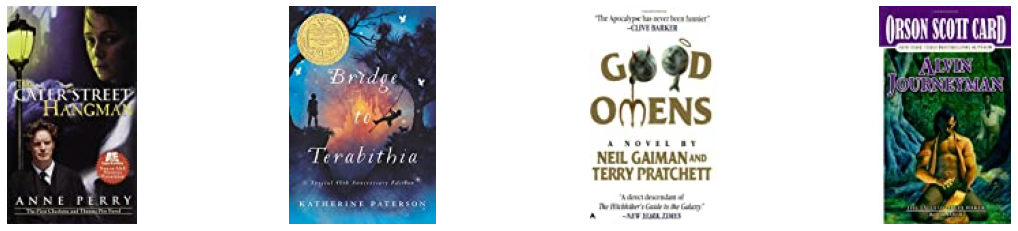

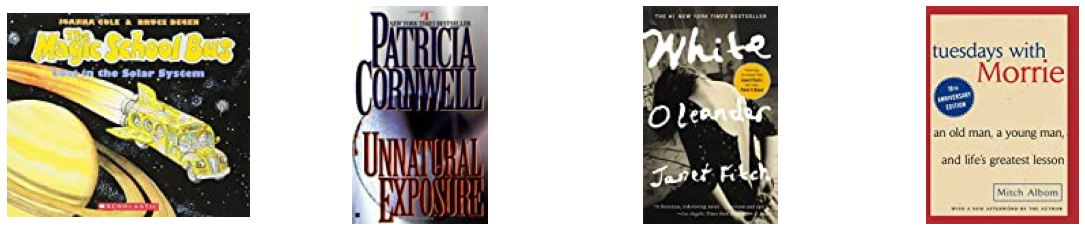

In [33]:
A = TopBooks(interaction_df=interactions, users_df=users, age=5, country='us', state='new york', locality='nyc')

<font size=4>Ну, как-то работает, не учитывается нормальный средний рейтинг

# 2. Рекомендации на основе метода кластеризации похожих пользователей

In [46]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

In [47]:
csr_rates.toarray()

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [48]:
s = pairwise_distances(csr_rates, metric='cosine')

In [49]:
s.shape

(10960, 10960)

In [50]:
len(interactions['User-ID'].unique())

10960

In [51]:
min_pts = 100
nn = NearestNeighbors(n_neighbors=min_pts)
nn.fit(s)

NearestNeighbors(n_neighbors=100)

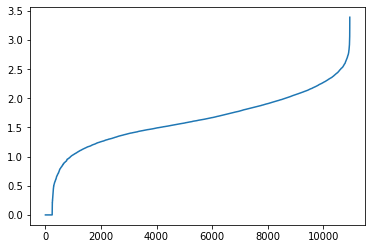

In [52]:
d, idx = nn.kneighbors(s, return_distance=True)
d_neigh = d[:, 1]
d_neigh = np.sort(d_neigh)
plt.plot(d_neigh)

In [278]:
%%time
eps = 1.58
min_pts = 12
dbscan = DBSCAN(eps=eps, min_samples=min_pts)
dbscan.fit(s)

CPU times: user 1min 59s, sys: 5.34 s, total: 2min 4s
Wall time: 36.3 s


DBSCAN(eps=1.58, min_samples=12)

In [279]:
books.shape

(271360, 8)

In [280]:
labels = dbscan.labels_

In [281]:
len(set(labels))

10

In [290]:
link_vid_labels = pd.DataFrame({'labels': labels, 'vid': np.arange(labels.shape[0])})

In [291]:
link_vid_labels.head()

,labels,vid
0,-1,0
1,-1,1
2,-1,2
3,-1,3
4,-1,4


In [292]:
interactions_with_labels = interactions.copy(deep=True)

In [293]:
interactions_with_labels = interactions_with_labels.merge(link_vid_labels, on='vid')

In [296]:
interactions_with_labels[interactions_with_labels['labels'] == 1]

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid,labels
23474,33517,0316666343,10,707,20,http://images.amazon.com/images/P/0316666343.0...,The Lovely Bones: A Novel,1690,1328,1
23475,33517,0330332775,8,72,20,http://images.amazon.com/images/P/0330332775.0...,Bridget Jones's Diary,1774,1328,1
23476,33517,0446520756,8,7,20,http://images.amazon.com/images/P/0446520756.0...,Legally Correct Fairy Tales,4877,1328,1
23477,33517,0304345350,9,8,20,http://images.amazon.com/images/P/0304345350.0...,Dictionary of Superstitions,1312,1328,1
23478,33517,0786886323,8,13,20,http://images.amazon.com/images/P/0786886323.0...,Carter Beats the Devil,8954,1328,1
...,...,...,...,...,...,...,...,...,...,...
29020,233041,0515115630,10,11,32,http://images.amazon.com/images/P/0515115630.0...,Family Blessings,6007,9133,1
29021,233041,051513449X,10,19,32,http://images.amazon.com/images/P/051513449X.0...,Guilty Pleasures (Anita Blake Vampire Hunter (...,6144,9133,1
29154,248727,0316666343,9,707,7,http://images.amazon.com/images/P/0316666343.0...,The Lovely Bones: A Novel,1690,9825,1
29155,248727,3596282225,9,11,7,http://images.amazon.com/images/P/3596282225.0...,Die Nebel von Avalon. Roman.,10593,9825,1


In [287]:
interactions_with_labels.shape

(110519, 10)

In [288]:
def recomendation(user_id):
    cluster_id = interactions_with_labels[interactions_with_labels['vid'] == user_id]['labels'].values[0]
    cluster_df = interactions_with_labels[interactions_with_labels['labels'] == cluster_id]
    print(f'cluster_id: {cluster_id}')
    df = pd.DataFrame(cluster_df.groupby('product_id', as_index=False)['Book-Rating'].sum().reset_index())
    df['Book-Rating'] = df['Book-Rating'] / cluster_df.shape[0]
    df = df.sort_values(by='Book-Rating', ascending=False).head(10)
    links = df.merge(interactions[['picture_url', 'product_id',]], on='product_id')\
            .drop_duplicates() \
            .reset_index()['picture_url']
    simple_rec_imaging(links)

cluster_id: 1


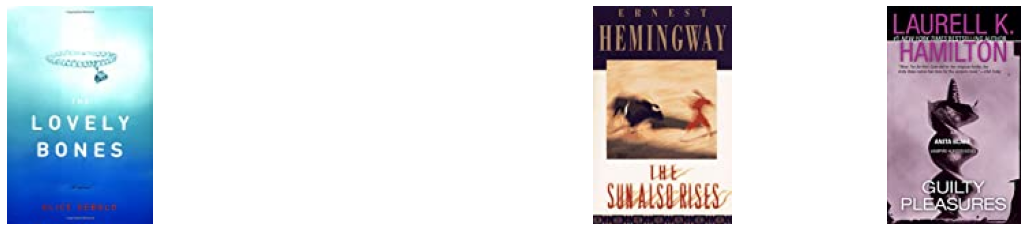

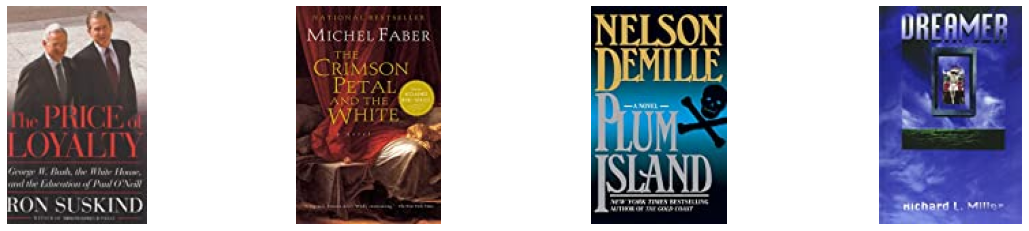

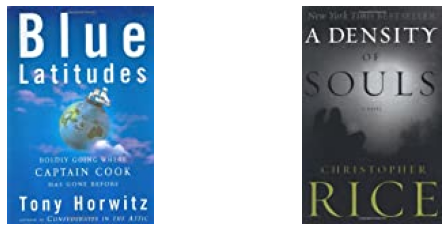

In [297]:
recomendation(1328)

# 3. Совстречаемость, Content-based, Коллаборативная фильтрация, Матричная Факторизация

<font size=4>Совстречаемость. Просто применяется класс из лекции.

In [35]:
Int_tmp = interactions[["vid", "product_id"]].drop_duplicates()

In [36]:
user_products = Int_tmp.groupby(["vid"])["product_id"].apply(list).reset_index()

In [37]:
class Recomendations():
    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id"]].drop_duplicates()
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        user_products = user_products[user_products["prod_num"] > 1]
        
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += 1
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Книга")
        rec_imaging([i], self.product_id_to_url)
        print(u"Рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [23]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

<ipython-input-22-49a565f6cf0b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(user_products.values):


  0%|          | 0/10012 [00:00<?, ?it/s]

In [24]:
cooc_rec.cooc_rec.sort_values("measure", ascending=False)
pass

Книга


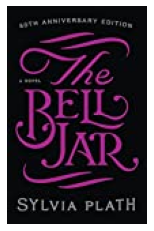

Рекомендации


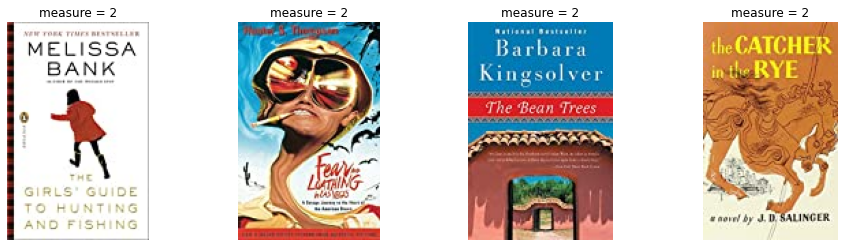

In [28]:
cooc_rec.get_rec(112)

<font size=4>Едем дальше: Content-based. Аналогично.

In [22]:
class Content_Based():
    def __init__(self, items, interactions):
        self.items = items
        self.interactions = interactions.drop_duplicates()
        self.content_dict = {}
        for i, j in enumerate(items["picture_url"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}
        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.items['text']]
        #build vocabulary and train model
        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        self.items_embs = np.zeros((len(item_description), 200))
        for i in range(self.items_embs.shape[0]):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])


    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]
        user_vector = " ".join(ui["text"])
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["picture_url"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [23]:
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [24]:
books_df = books.copy(deep=True)
books_df.rename(columns={'Image-URL-S': 'picture_url'}, inplace=True)
books_df.drop(columns=['Image-URL-M', 'Image-URL-L'], inplace=True)
books_df['text'] = \
    books_df.iloc[:, 0].astype(str) + " " + \
    books_df.iloc[:, 1].astype(str) + " " + \
    books_df.iloc[:, 2].astype(str) + " " + \
    books_df.iloc[:, 3].astype(str) + " " + \
    books_df.iloc[:, 4].astype(str)
books_df.head(4)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,picture_url,text
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,0195153448 Classical Mythology Mark P. O. Morf...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,0002005018 Clara Callan Richard Bruce Wright 2...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,0060973129 Decision in Normandy Carlo D'Este 1...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,0374157065 Flu: The Story of the Great Influen...


In [26]:
ContentBased_recomendations = Content_Based(books_df, interactions)
ContentBased_recomendations.get_items_representation()

Для товара


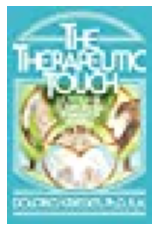

Такие рекомендации


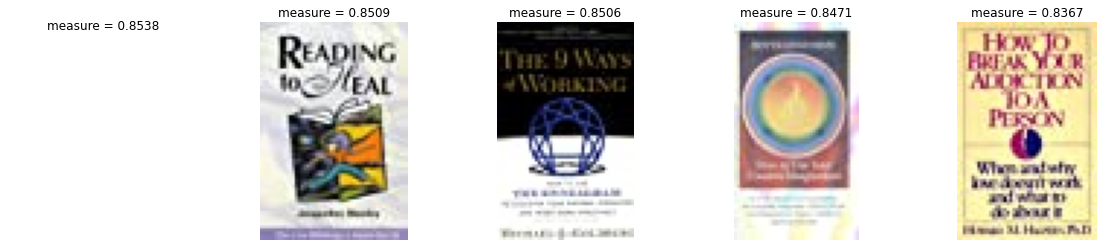

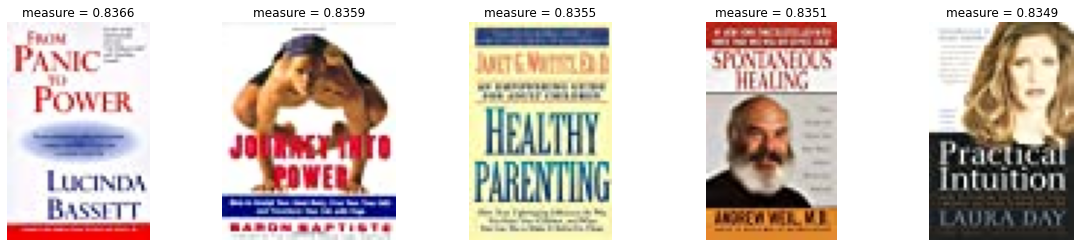

In [34]:
ContentBased_recomendations.get_rec_I2I(42)

<font size=4>Матричная факторизация

In [38]:
class MatrixFactorization():
    
    def __init__(self, interactions, k):
        interactions["product_id"] = interactions["product_id"].astype(int)
        self.k = k
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i] = j
        df_weights = pd.DataFrame({"rating": [0, 1, 2],
                                   'weight': [1, 1, 1]})
        weighted = interactions.merge(df_weights, on="rating")\
                          .groupby(["vid", "product_id", "picture_url"])["weight"]\
                          .sum()\
                          .reset_index()
        weighted["weight"] = (weighted["weight"] > 0).astype(int)
        self.csr_rates = coo_matrix((weighted["weight"], (weighted["vid"], weighted["product_id"])), 
                            shape=(len(set(weighted["vid"])), len(set(weighted["product_id"]))))
        
    def MF(self):
        U, S, V = svds(self.csr_rates.astype(float), k=self.k)
        self.user_embs = U
        self.items_embs = V.T
        
    def LightFM(self):
        self.model = LightFM(loss='warp', no_components=100, learning_rate=0.03, learning_schedule="adadelta")
        self.model.fit(self.csr_rates, epochs=5, num_threads=40, verbose=True)
        self.user_feature_bias, self.user_feature_embeddings = self.model.get_user_representations()
        self.item_feature_bias, self.items_embs = self.model.get_item_representations()

    def get_rec(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))

In [42]:
interactions_ = interactions.copy(deep=True)
interactions_['rating'] = interactions_['Book-Rating']
interactions_.loc[(interactions_['Book-Rating'] >= 1) & (interactions_['Book-Rating'] <= 5), 'rating'] = 0
interactions_.loc[(interactions_['Book-Rating'] > 5) & (interactions_['Book-Rating'] <= 7), 'rating'] = 1
interactions_.loc[(interactions_['Book-Rating'] > 7) & (interactions_['Book-Rating'] <= 10), 'rating'] = 2
interactions_.head(5)

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid,rating
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445,2
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248,2
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622,2
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887,2
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228,1


In [44]:
rec = MatrixFactorization(interactions_, 30)
rec.MF()

Для товара


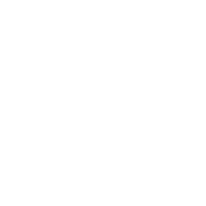

Такие рекомендации


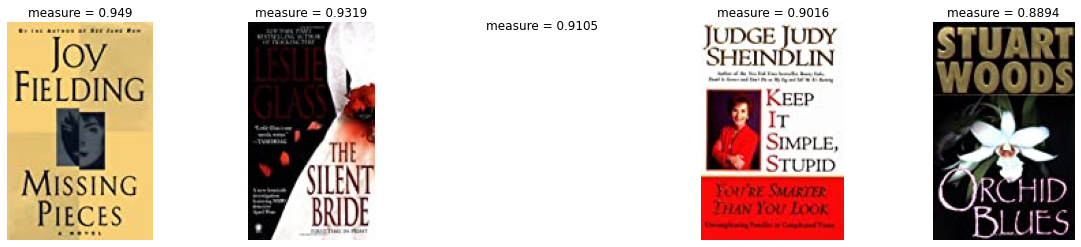

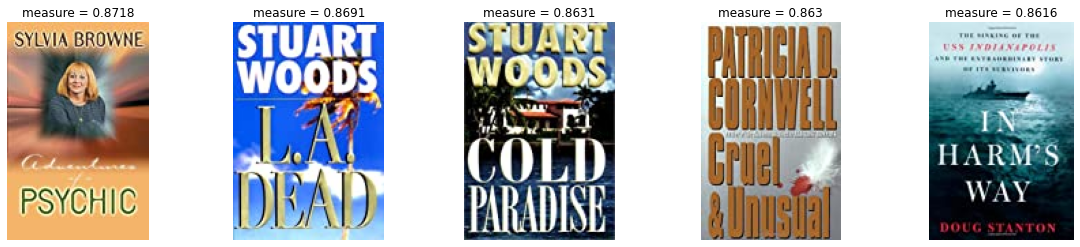

In [45]:
rec.get_rec(123)